## Análisis del dataset para la implementación de modelos predictivos ##

<a id='Volver_indice'></a>

***Importación de librerías***

In [2]:
#importación de librerías básicas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import datetime

# importación de librerias para análisis de modelos y métricas
%matplotlib inline
from sklearn import metrics
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, binarize
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFECV, RFE, chi2
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set()
sns.set_context("talk")

[Volver al índice](#Volver_indice)
<a href='#Volver_indice'></a> 

### Análisis descriptivo del dataset ###

In [3]:
%%time
data = pd.read_csv('para_ejercitacion_con_RCVG_1.csv',sep=';',encoding='utf_8')

data = data.drop_duplicates()
now = datetime.datetime.now()
data['EDAD']= (now - pd.to_datetime(data['FECHA DE NACIMIENTO'])).astype('<m8[Y]') 
data.rename(columns={'ENF. CARDIOVASCULAR ESTABLECIDA':'ENF.CARDIOVASCULAR_ESTABLECIDA'},inplace=True)

# df va a ser el dataset que se va a utilizar para predecir
df = data[['TAS','TAD','SEXO', 'DIABETES', 'DISLIPEMIA', 'OBESIDAD','UTMO_IMC', 'CLASIFICACION_IMC', 'CLEARANCE','COLESTEROL_TOTAL','EDAD','HIPERTENSION']]
df = df.dropna()

df = pd.get_dummies(df, prefix=['SEXO', 'DIABETES', 'DISLIPEMIA', 'OBESIDAD','CLASIFICACION_IMC','HIPERTENSION'], columns=['SEXO', 'DIABETES', 'DISLIPEMIA', 'OBESIDAD','CLASIFICACION_IMC','HIPERTENSION'],drop_first = True)

#print(data.columns)
print('Columnas iniciales que se consideran para predecir hipertensión:\n', df.columns)
print('\nDimensiones del dataset a analizar:',  df.shape)
hta_counts = df.HIPERTENSION_SI.value_counts(normalize=True)
print('\nPorcentaje de no hipertensos:', round(hta_counts[0],3))
print('\nPorcentaje de hipertensos:', round(hta_counts[1],3))

Columnas iniciales que se consideran para predecir hipertensión:
 Index(['TAS', 'TAD', 'UTMO_IMC', 'CLEARANCE', 'COLESTEROL_TOTAL', 'EDAD',
       'SEXO_MASCULINO', 'DIABETES_DM2', 'DIABETES_NO', 'DISLIPEMIA_SI',
       'OBESIDAD_SI', 'CLASIFICACION_IMC_NORMAL', 'CLASIFICACION_IMC_OBESIDAD',
       'CLASIFICACION_IMC_SOBREPESO', 'HIPERTENSION_SI'],
      dtype='object')

Dimensiones del dataset a analizar: (11995, 15)

Porcentaje de no hipertensos: 0.632

Porcentaje de hipertensos: 0.368
CPU times: total: 750 ms
Wall time: 788 ms


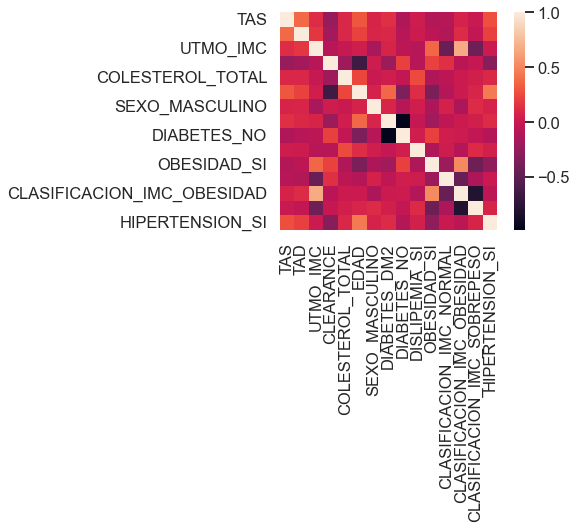

In [4]:
sns.heatmap(df.corr(),square=True);

In [5]:
display(df.corr())

,TAS,TAD,UTMO_IMC,CLEARANCE,COLESTEROL_TOTAL,EDAD,SEXO_MASCULINO,DIABETES_DM2,DIABETES_NO,DISLIPEMIA_SI,OBESIDAD_SI,CLASIFICACION_IMC_NORMAL,CLASIFICACION_IMC_OBESIDAD,CLASIFICACION_IMC_SOBREPESO,HIPERTENSION_SI
TAS,1.000000,0.373259,0.117725,-0.236026,0.092405,0.298778,0.072046,0.135030,-0.130956,0.020998,-0.112089,-0.093509,0.068126,-0.004601,0.267921
TAD,0.373259,1.000000,0.165450,-0.181286,0.087609,0.223941,0.081750,0.094201,-0.090545,0.009635,-0.062504,-0.113101,0.109476,-0.036829,0.212572
UTMO_IMC,0.117725,0.165450,1.000000,-0.089854,-0.012893,0.036530,-0.157508,0.070989,-0.055384,-0.093338,0.361515,-0.443536,0.667073,-0.428110,0.004170
CLEARANCE,-0.236026,-0.181286,-0.089854,1.000000,-0.206291,-0.658797,0.020981,-0.216122,0.212669,-0.089430,0.223248,0.132182,-0.074972,-0.022722,-0.308472
COLESTEROL_TOTAL,0.092405,0.087609,-0.012893,-0.206291,1.000000,0.238297,-0.007817,0.034578,-0.034201,0.248065,-0.129990,-0.056025,-0.000586,0.043095,0.094701
EDAD,0.298778,0.223941,0.036530,-0.658797,0.238297,1.000000,0.067595,0.366185,-0.354797,0.118213,-0.361393,-0.104310,0.006311,0.079839,0.445232
SEXO_MASCULINO,0.072046,0.081750,-0.157508,0.020981,-0.007817,0.067595,1.000000,0.081929,-0.088255,0.030412,-0.137550,0.055249,-0.140136,0.115071,0.063704
DIABETES_DM2,0.135030,0.094201,0.070989,-0.216122,0.034578,0.366185,0.081929,1.000000,-0.986277,-0.029613,-0.194214,-0.054926,0.000291,0.041399,0.108233
DIABETES_NO,-0.130956,-0.090545,-0.055384,0.212669,-0.034201,-0.354797,-0.088255,-0.986277,1.000000,0.031482,0.208401,0.030959,0.013983,-0.038946,-0.100470
DISLIPEMIA_SI,0.020998,0.009635,-0.093338,-0.089430,0.248065,0.118213,0.030412,-0.029613,0.031482,1.000000,-0.131752,0.015402,-0.101413,0.103722,0.050048


In [6]:
df.describe()
# se observan outliers

,TAS,TAD,UTMO_IMC,CLEARANCE,COLESTEROL_TOTAL,EDAD,SEXO_MASCULINO,DIABETES_DM2,DIABETES_NO,DISLIPEMIA_SI,OBESIDAD_SI,CLASIFICACION_IMC_NORMAL,CLASIFICACION_IMC_OBESIDAD,CLASIFICACION_IMC_SOBREPESO,HIPERTENSION_SI
count,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000
mean,125.016924,77.296207,33.876969,97.810954,183.751582,49.325636,0.312547,0.315882,0.678116,0.120550,0.739808,0.070279,0.729554,0.194164,0.368404
std,29.247829,18.169841,6.931371,31.151028,43.530877,18.599964,0.463551,0.464885,0.467218,0.325617,0.438757,0.255628,0.444209,0.395572,0.482392
min,11.000000,7.000000,4.030000,0.160000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,110.000000,70.000000,29.590000,78.270000,154.000000,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,120.000000,80.000000,33.080000,95.990000,180.000000,52.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,140.000000,83.000000,37.640000,113.545000,210.000000,63.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,1580.000000,802.000000,78.490000,299.960000,593.000000,101.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
# restriccion general en cuando a la edad del grupo etario a considerar en df
indexNames1=df[df.EDAD < 30].index
df.drop(indexNames1, inplace=True)
indexNames2=df[df.EDAD >78].index
df.drop(indexNames2, inplace=True)
print ('Cantidad de registros de df filtrado por edad:', df.shape[0])
df.EDAD

Cantidad de registros de df filtrado por edad: 9451


975      76.0
1184     76.0
1320     77.0
1390     77.0
1452     74.0
         ... 
59739    70.0
59788    44.0
59798    44.0
59876    43.0
59964    59.0
Name: EDAD, Length: 9451, dtype: float64

### Eliminacion de outliers ###

In [8]:
def rango_extremos(frame, label, quant_list):
    for i,v in enumerate(quant_list):
        if v > 0 and v < 100:
            quant_list[i] = v/100

    rango_outlier = frame[label].quantile(quant_list)
    return round(rango_outlier,2)

In [9]:
#Filtro valores_extremos en df segun percentiles
for v in ['COLESTEROL_TOTAL','CLEARANCE','UTMO_IMC','TAS','TAD']:
    rango_outlier = rango_extremos(df, v, [0.8, 99.8])
    rango_outlier=list(rango_outlier)
    mascara_outlier= (df[v]>= rango_outlier[0]) & (df[v] <= rango_outlier[1])
    df = df.drop(df[mascara_outlier == False].index)
    #print ('Cantidad de elementos iniciales: {}'.format(df.shape[0]))
    #print ('Cantidad de outliers encontrados: {}'.format(mascara_outlier_COL[mascara_outlier_COL == False].count()))
    #print ('Porcentaje de reduccion de registros de la categoría: {}%'.format(round(mascara_outlier_COL[mascara_outlier_COL == False].count()/df.shape[0]*100 ,2)))

print(df.shape[0])

9040


In [10]:
# dataset df sin outliers
df.describe()

,TAS,TAD,UTMO_IMC,CLEARANCE,COLESTEROL_TOTAL,EDAD,SEXO_MASCULINO,DIABETES_DM2,DIABETES_NO,DISLIPEMIA_SI,OBESIDAD_SI,CLASIFICACION_IMC_NORMAL,CLASIFICACION_IMC_OBESIDAD,CLASIFICACION_IMC_SOBREPESO,HIPERTENSION_SI
count,9040.000000,9040.000000,9040.000000,9040.000000,9040.000000,9040.000000,9040.000000,9040.000000,9040.000000,9040.000000,9040.000000,9040.000000,9040.000000,9040.000000,9040.000000
mean,127.592367,79.193695,34.670607,91.840117,190.108605,54.088606,0.300996,0.367699,0.628319,0.141593,0.718695,0.039381,0.774889,0.185509,0.418252
std,18.808709,11.768482,6.505123,22.285506,41.316529,12.407463,0.458716,0.482206,0.483281,0.348651,0.449661,0.194509,0.417678,0.388731,0.493299
min,90.000000,55.000000,21.160000,15.330000,100.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,118.000000,70.000000,30.317500,76.900000,161.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,125.000000,80.000000,33.690000,92.910000,186.000000,55.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,140.000000,90.000000,38.242500,106.275000,215.000000,64.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,200.000000,120.000000,63.150000,167.970000,380.000000,78.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
df_data = df[['TAD','TAS','UTMO_IMC','CLEARANCE','COLESTEROL_TOTAL','EDAD']]
df_data

,TAD,TAS,UTMO_IMC,CLEARANCE,COLESTEROL_TOTAL,EDAD
975,70.0,110.0,36.41,18.52,125.0,76.0
1184,60.0,130.0,40.46,76.34,131.0,76.0
1320,90.0,150.0,30.40,60.20,225.0,77.0
1390,80.0,155.0,30.70,59.73,165.0,77.0
1452,60.0,130.0,30.04,61.69,109.0,74.0
...,...,...,...,...,...,...
59737,100.0,150.0,40.40,119.75,182.0,35.0
59739,83.0,137.0,23.20,77.15,191.0,70.0
59788,60.0,110.0,47.66,114.15,165.0,44.0
59876,80.0,155.0,41.04,70.88,261.0,43.0


Correlación de las variables con TAS

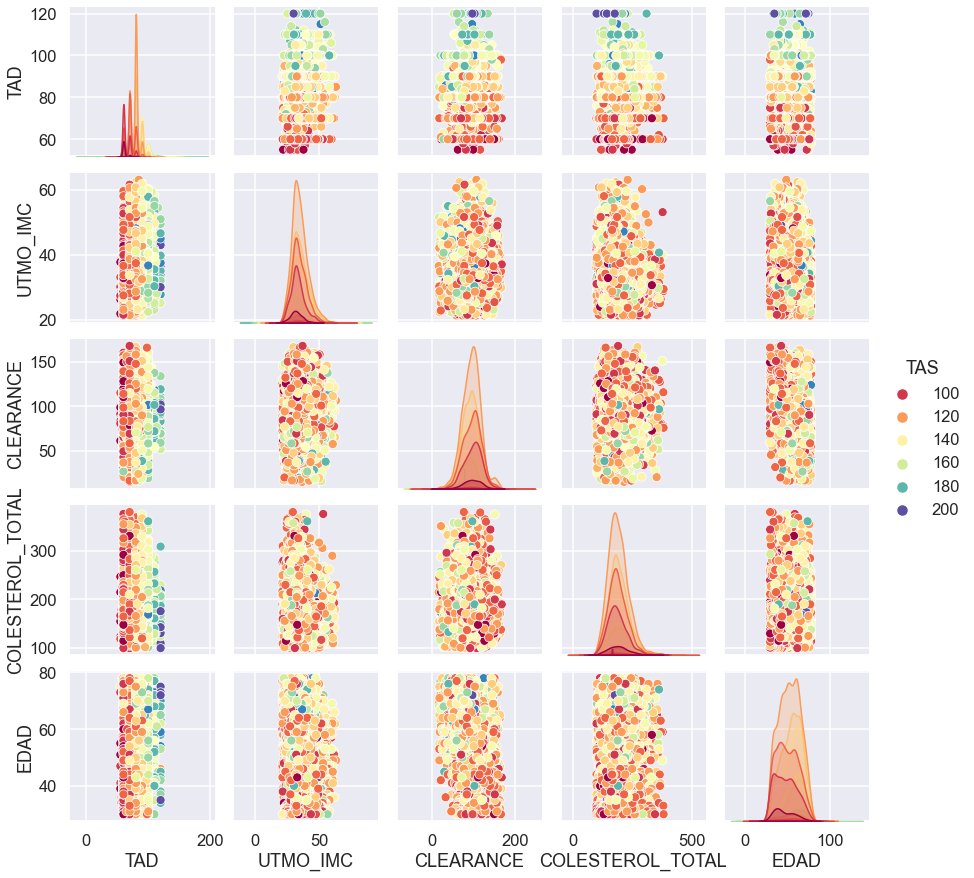

In [12]:
g=sns.pairplot(df_data, hue="TAS", palette="Spectral" )

In [13]:
# como quedaron las clases a predecir en df
print(df.shape)
df.HIPERTENSION_SI.value_counts(normalize=True)

(9040, 15)


0    0.581748
1    0.418252
Name: HIPERTENSION_SI, dtype: float64

<font color='pink'>* Notamos que las clases estan algo desbalanceadas. 

### Implementación del modelo Regresión lineal ###

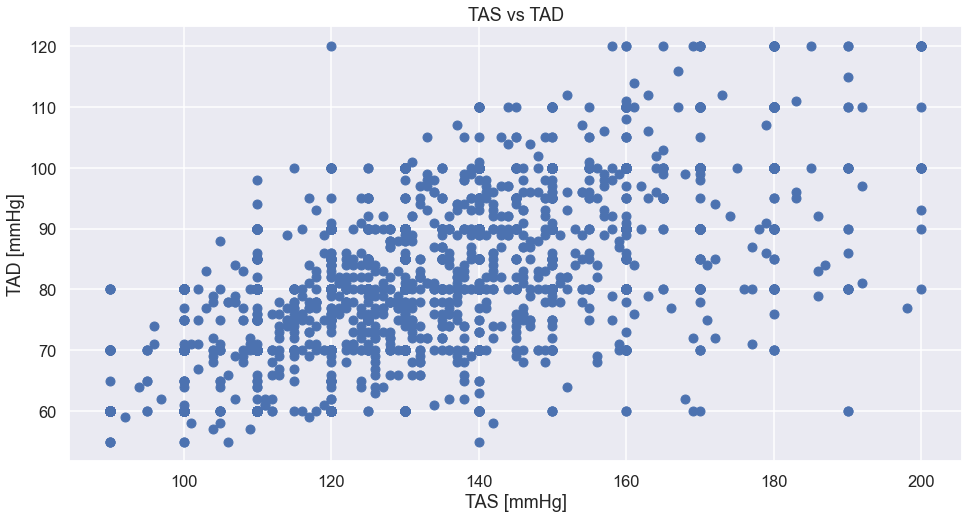

In [14]:
df_data.plot(x='TAS', y='TAD', style='o', figsize=(16, 8), legend=None)  
plt.title("TAS vs TAD")
plt.xlabel("TAS [mmHg]")
plt.ylabel("TAD [mmHg]")
plt.show()

<Figure size 1080x720 with 0 Axes>

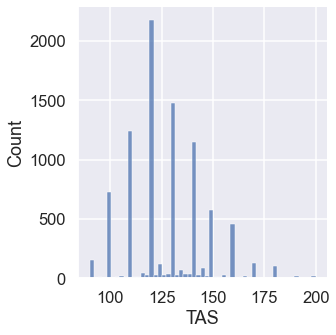

In [15]:
#Se grafican lo valores que alcanza la TAS

plt.figure(figsize=(15,10))
plt.tight_layout()
sns.displot(df_data['TAS'])

In [16]:
X = df_data['TAS'].values.reshape(-1,1)
y = df_data['TAD'].values.reshape(-1,1)
df_mod = pd.DataFrame({'X': X.flatten(), 'y': y.flatten()})
df_mod

,X,y
0,110.0,70.0
1,130.0,60.0
2,150.0,90.0
3,155.0,80.0
4,130.0,60.0
...,...,...
9035,150.0,100.0
9036,137.0,83.0
9037,110.0,60.0
9038,155.0,80.0


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
df_mod = pd.DataFrame({'X_train': X_train.flatten(), 'y_train': y_train.flatten()})
df_mod.head()

,X_train,y_train
0,110.0,70.0
1,170.0,100.0
2,120.0,80.0
3,120.0,80.0
4,100.0,60.0


In [18]:
df_aux = pd.DataFrame({'X_test': X_test.flatten(), 'y_test': y_test.flatten()})
df_mod.head()

,X_train,y_train
0,110.0,70.0
1,170.0,100.0
2,120.0,80.0
3,120.0,80.0
4,100.0,60.0


In [19]:
regressor = LinearRegression() 
regressor.fit(X_train, y_train) 

LinearRegression()

In [20]:
print(regressor.intercept_)

[22.24075014]


In [21]:
print(regressor.coef_)

[[0.44652433]]


Esto significa que por cada unidad de cambio en la TAS, el cambio en la TAD es de alrededor de 0,45%.

In [22]:
y_pred = regressor.predict(X_test)

Comparación entre el valor real y el valor de predicción

In [23]:
df_mod = pd.DataFrame({'Real': y_test.flatten(), 'Predicted': y_pred.flatten()})
df_mod

,Real,Predicted
0,80.0,80.288913
1,70.0,80.288913
2,60.0,71.358426
3,70.0,75.823669
4,78.0,72.697999
...,...,...
2707,80.0,85.200680
2708,80.0,80.288913
2709,70.0,71.358426
2710,80.0,71.358426


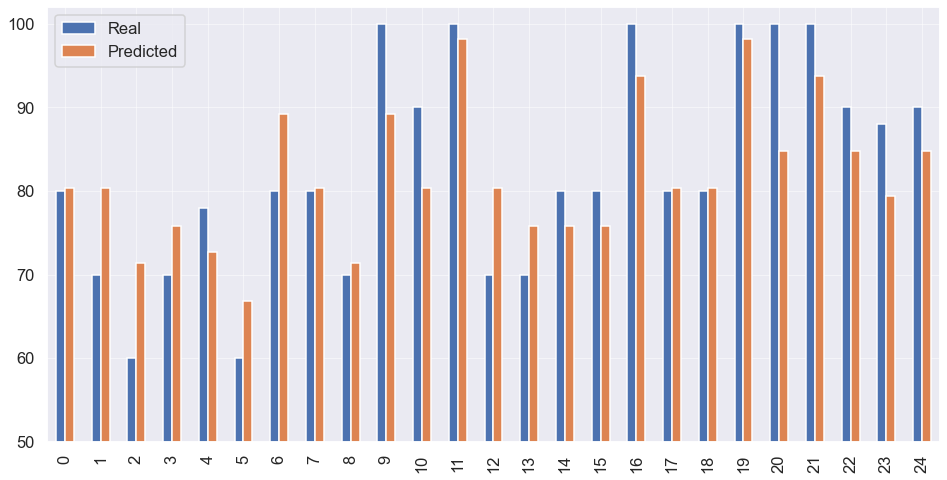

In [29]:
df_rl = df_mod.head(25)
df_rl.plot(kind='bar',figsize=(16,8))
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.ylim(50, 102)
plt.show()

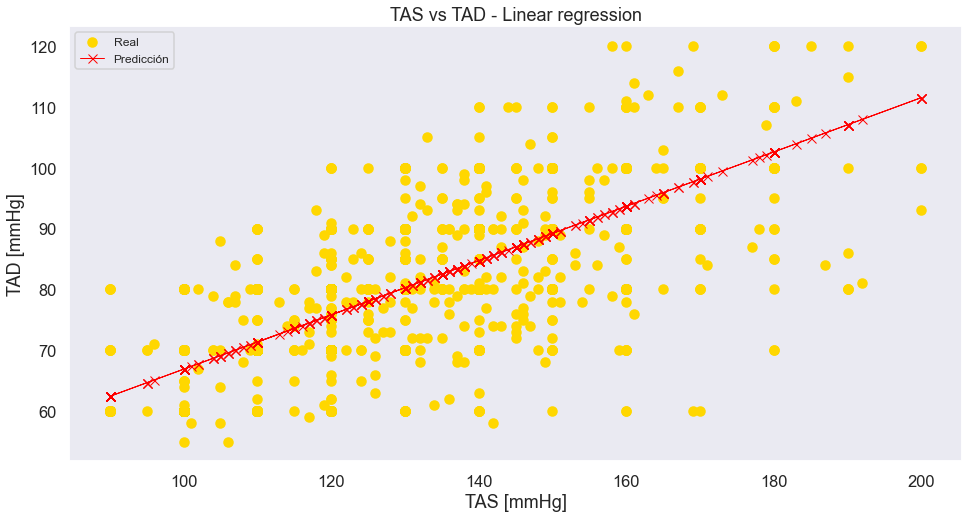

In [30]:
plt.figure(figsize=(16, 8))
plt.scatter(X_test, y_test,  color='gold', label="Real")
plt.plot(X_test, y_pred, color='red', linewidth=1, marker='x', label="Predicción")
plt.title("TAS vs TAD - Linear regression")
plt.xlabel("TAS [mmHg]")
plt.ylabel("TAD [mmHg]")
plt.legend(loc="upper left", fontsize=12)
plt.grid()
plt.show()

Medición de métricas para la evaluación del modelo de Regresión lineal simple

In [31]:
print('Error Absoluto Medio:',metrics.mean_absolute_error(y_test, y_pred)) 
print('Error Cuadratico Medio:', metrics.mean_squared_error(y_test, y_pred)) 
print('Raíz del error cuadrático medio:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Error Absoluto Medio: 6.544789784197129
Error Cuadratico Medio: 69.99742325016946
Raíz del error cuadrático medio: 8.366446273667778


***Implementación del modelo de Regresión lineal múltiple***

In [32]:
X = df[['TAD', 'EDAD', 'UTMO_IMC', 'CLEARANCE', 'COLESTEROL_TOTAL']].values
y = df['TAS'].values

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [34]:
regressor = LinearRegression() 
regressor.fit(X_train, y_train)

LinearRegression()

In [35]:
print (regressor.intercept_)

20.343725095713893


In [36]:
list(zip(df, regressor.coef_))

[('TAS', 1.0983101921223155),
 ('TAD', 0.3169279045798239),
 ('UTMO_IMC', 0.12400677441523468),
 ('CLEARANCE', -0.009021069988688624),
 ('COLESTEROL_TOTAL', -0.00138148376350411)]

In [37]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred)) 
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred)) 
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 48.06188500454516
Mean Squared Error: 2417.080585670002
Root Mean Squared Error: 49.1638137828017


In [41]:
print(regressor.summary())

AttributeError: 'LinearRegression' object has no attribute 'summary'

***Implementación del modelo de Regresión de Ridge y Lasso con Cross validation***

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
lr = linear_model.LinearRegression()
cv = KFold(5, shuffle=True)
scores = cross_val_score(lr, X_train, y_train, cv=cv, scoring='r2')
scores, scores.mean()

(array([0.54359782, 0.54875815, 0.56344481, 0.52229868, 0.5526797 ]),
 0.5461558320518505)

In [43]:
model = linear_model.LassoCV().fit(X_train, y_train)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean(), zero_coefs=(model.coef_ == 0).sum())

{'alpha': 0.1549958517699115,
 'scores': array([0.54565444, 0.56056537, 0.55514574, 0.52128477, 0.54913208]),
 'mean_score': 0.5463564810688909,
 'zero_coefs': 0}

In [44]:
model = linear_model.LassoCV(normalize=True).fit(X, y)
scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean(), zero_coefs=(model.coef_ == 0).sum())

{'alpha': 0.0015132739021451902,
 'scores': array([0.54727721, 0.53218873, 0.54048137, 0.55939207, 0.57824376]),
 'mean_score': 0.55151662756688,
 'zero_coefs': 2}

In [45]:
model = linear_model.RidgeCV(normalize=True).fit(X, y)
scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
dict(alpha=model.alpha_, scores=scores, mean_score=scores.mean())

{'alpha': 0.1,
 'scores': array([0.55614987, 0.52409072, 0.52750112, 0.56686177, 0.56275887]),
 'mean_score': 0.547472470405959}

***Implementación del modelo Random Forest***

In [46]:
X = df.drop('HIPERTENSION_SI',axis=1)
y = df.HIPERTENSION_SI

In [47]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=0,stratify=y)
X_train_sc = scaler.fit_transform(X_train)
X_test_sc= scaler.transform(X_test)

In [48]:
model_RFC = RandomForestClassifier()
params = {"n_estimators": [50,100,150],"max_depth": [8,10,15,20,25],"random_state": [0]}
clf_RFC_grid = GridSearchCV(model_RFC, param_grid=params, verbose=1)

clf_RFC_grid = clf_RFC_grid.fit(X_train_sc, y_train.values.ravel())
RFC_grid_pred= clf_RFC_grid.predict(X_test_sc)
print('Cantidad de Datos: ', len(df))
print('Mejor Combinacion de Hiperparametros en Random Forest: ',clf_RFC_grid.best_params_)
print('Métricas: ')
print(classification_report(RFC_grid_pred, y_test))
print('Accuracy: ',accuracy_score(RFC_grid_pred, y_test))

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Cantidad de Datos:  9040
Mejor Combinacion de Hiperparametros en Random Forest:  {'max_depth': 8, 'n_estimators': 50, 'random_state': 0}
Métricas: 
              precision    recall  f1-score   support

           0       0.86      0.75      0.80      1794
           1       0.61      0.76      0.68       918

    accuracy                           0.76      2712
   macro avg       0.74      0.76      0.74      2712
weighted avg       0.77      0.76      0.76      2712

Accuracy:  0.7551622418879056


<font color='magenta'>*Se quiere evaluar con los resultados de GridSearchCV y RandomForest la importancia de los aspectos considerados para la prediccion*</font>

In [49]:
model_RCF_best = RandomForestClassifier(n_estimators = 100,max_depth = 10,random_state = 0)
model_RCF_best.fit(X_train_sc,y_train)

RandomForestClassifier(max_depth=10, random_state=0)

In [50]:
y_pred = model_RCF_best.predict(X_test_sc)

In [51]:
importancias = model_RCF_best.feature_importances_
print(importancias)

[0.14356685 0.0753635  0.09920858 0.12820296 0.08706407 0.20877968
 0.01440426 0.04551268 0.05097013 0.05479843 0.07222891 0.0038833
 0.00852138 0.00749527]


In [52]:
X.columns

Index(['TAS', 'TAD', 'UTMO_IMC', 'CLEARANCE', 'COLESTEROL_TOTAL', 'EDAD',
       'SEXO_MASCULINO', 'DIABETES_DM2', 'DIABETES_NO', 'DISLIPEMIA_SI',
       'OBESIDAD_SI', 'CLASIFICACION_IMC_NORMAL', 'CLASIFICACION_IMC_OBESIDAD',
       'CLASIFICACION_IMC_SOBREPESO'],
      dtype='object')

<AxesSubplot:title={'center':'Importancia de features: RandomForest con GridSearchCV'}>

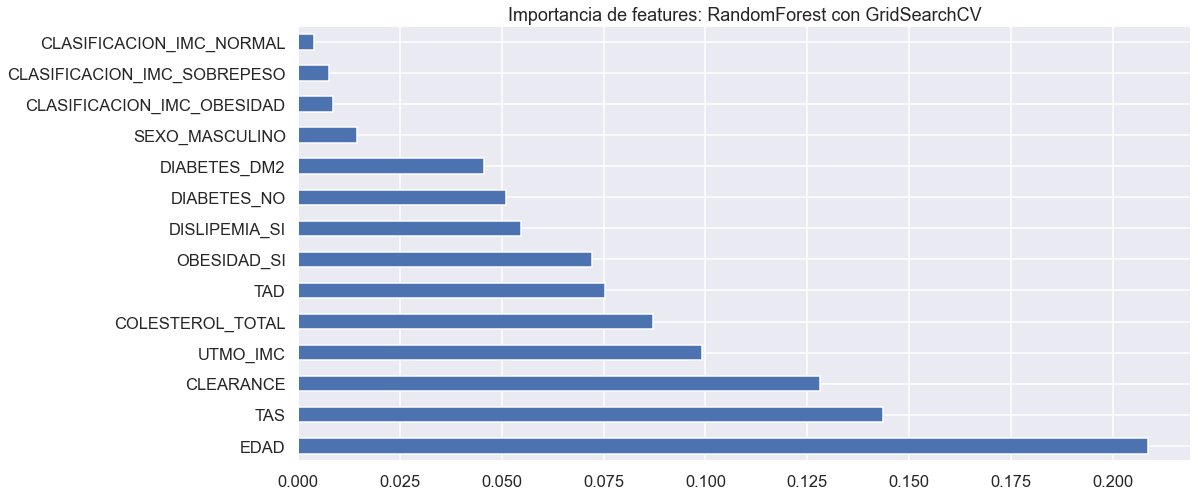

In [54]:
(pd.Series(importancias,index = X.columns).nlargest(14).plot(kind='barh', figsize=(16, 8), title='Importancia de features: RandomForest con GridSearchCV'))

<font color='pink'>*De acuerdo con los resultados de feature_importances las variables más influyentes en el modelo son: EDAD, OBESIDAD_SI,CLEARANCE, UTMO_IMC, COLESTEROL_TOTAL, TAS, TAD*</font>

In [55]:
confusion_matrix(y_test, RFC_grid_pred)

array([[1354,  224],
       [ 440,  694]], dtype=int64)

In [56]:
print('accuracy:', accuracy_score(y_test, RFC_grid_pred))
print('recall:', recall_score(y_test, RFC_grid_pred))
print('f1_score:',f1_score(y_test, RFC_grid_pred))
print('precision:', precision_score(y_test, RFC_grid_pred))

accuracy: 0.7551622418879056
recall: 0.6119929453262787
f1_score: 0.6764132553606238
precision: 0.7559912854030502


<font color='magenta'>*Se efectua una prueba del modelo random forest reduciendo las features (segun feature_importances) para ver como resultan las metricas en este caso*</font>

In [57]:
columns = ['TAS','TAD','UTMO_IMC', 'CLEARANCE', 'COLESTEROL_TOTAL',
       'EDAD', 'OBESIDAD_SI','HIPERTENSION_SI']

In [58]:
df_new = df[columns]
df_new.shape

(9040, 8)

In [59]:
X = df_new.drop('HIPERTENSION_SI',axis=1)
y = df_new.HIPERTENSION_SI

In [60]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1, stratify=y)
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [61]:
model_RFC_red = RandomForestClassifier()
params = {"n_estimators": [50,100,300], "max_depth": [8,10,15,20,25], "random_state": [0]}
clf_RFC_grid_red = GridSearchCV(model_RFC_red, param_grid=params, verbose=1)

clf_RFC_grid_red = clf_RFC_grid_red.fit(X_train_sc, y_train.values.ravel())
RFC_grid_red_pred = clf_RFC_grid_red.predict(X_test_sc)
#print('Cantidad de Datos: ',len(df))
print('Mejor Combinacion de Hiperparametros en Random Forest: ',clf_RFC_grid_red.best_params_)
print('Reporte: ')
print(classification_report(RFC_grid_red_pred, y_test))
print('Accuracy: ',accuracy_score(RFC_grid_red_pred, y_test))

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Mejor Combinacion de Hiperparametros en Random Forest:  {'max_depth': 8, 'n_estimators': 100, 'random_state': 0}
Reporte: 
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       824
           1       0.60      0.64      0.62       532

    accuracy                           0.69      1356
   macro avg       0.68      0.68      0.68      1356
weighted avg       0.70      0.69      0.69      1356

Accuracy:  0.6910029498525073


In [62]:
confusion_matrix(RFC_grid_red_pred,y_test)

array([[597, 227],
       [192, 340]], dtype=int64)

In [63]:
print('accuracy:', accuracy_score(y_test, RFC_grid_red_pred))
print('recall:',recall_score(y_test, RFC_grid_red_pred))
print('f1_score:',f1_score(y_test, RFC_grid_red_pred))
print('precision:', precision_score(y_test, RFC_grid_red_pred))

accuracy: 0.6910029498525073
recall: 0.599647266313933
f1_score: 0.618744313011829
precision: 0.6390977443609023


In [64]:
model_RFC_red.plot_tree(my_tree,feature_names = X.columns,filled=True,rounded=True)
print()

AttributeError: 'RandomForestClassifier' object has no attribute 'plot_tree'

<font color='pink'>*Los valores de accuracy casi no se modificaron al considerar menos aspectos. La unica diferencia significativa es que se consigue el mismo resultado pero ahora con 100 estimadores y una profundidad igual a 8*</font>